# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

## 1. Importing your libraries and data

### Explaining the Reason for Using `requests` and NOT `Quandl` library for FRED Data

Initially, I attempted to retrieve the **"Natural Rate of Unemployment"** dataset (`FRED/NROU`) using the `quandl` and `nasdaq-data-link` Python packages. However, both approaches consistently returned a **403 Forbidden error** or an **Error 15** from Nasdaq’s security service. Even after regenerating the API key, switching networks, and running the code in Google Colab, access remained blocked.

As a result, I switched to using the official **FRED API via the `requests` library**, which provided reliable access to the same dataset directly from its original source (https://fred.stlouisfed.org), bypassing the access issues encountered with third-party services.

In [4]:
import requests 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

## 2.  Subsetting, wrangling, and cleaning time-series data

In [6]:
# Generated API key from https://fred.stlouisfed.org
fred_api_key = "cfb78b56acf2c64ff93b708aef7436df"

url = f"https://api.stlouisfed.org/fred/series/observations?series_id=GS10&api_key={fred_api_key}&file_type=json"

response = requests.get(url)
data_json = response.json()

# Convert JSON to DataFrame
df = pd.DataFrame(data_json["observations"])

# Keep and clean only 'date' and 'value'
df = df[["date", "value"]]
df["date"] = pd.to_datetime(df["date"])
df["value"] = pd.to_numeric(df["value"], errors="coerce")
df.rename(columns={"date": "Date", "value": "Yield"}, inplace=True)
df.set_index("Date", inplace=True)

# Preview
print(df.head())
print(df.shape)


            Yield
Date             
1953-04-01   2.83
1953-05-01   3.05
1953-06-01   3.11
1953-07-01   2.93
1953-08-01   2.95
(867, 1)


In [11]:
df.columns

Index(['Yield'], dtype='object')

In [13]:
type(df)

pandas.core.frame.DataFrame

## 3. Make a subset if necessary and explain in markdown

In [19]:
# Resample to monthly average

df_monthly = df.resample("M").mean()

### Subsetting Logic

Since the dataset included daily values over many decades, the data is resampled into monthly averages to smooth short-term fluctuations and better observe seasonal and trend components. 

This step also helps avoid historical anomalies (e.g., extremely volatile short-term market events) that may bias decomposition or stationarity tests. By narrowing the granularity, the data becomes easier to interpret and model.

 ## 4. Create a line chart of your data

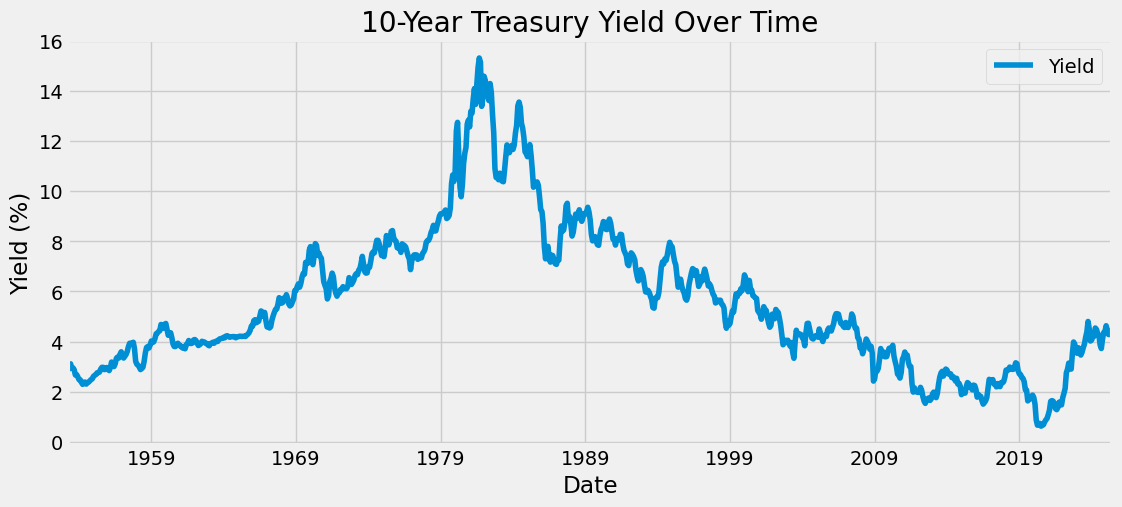

In [22]:
# Plot Raw Time Series

df_monthly.plot(figsize=(12,5), title="10-Year Treasury Yield Over Time")
plt.ylabel("Yield (%)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

## 5. Decompose the data's components and analyze results in markdown

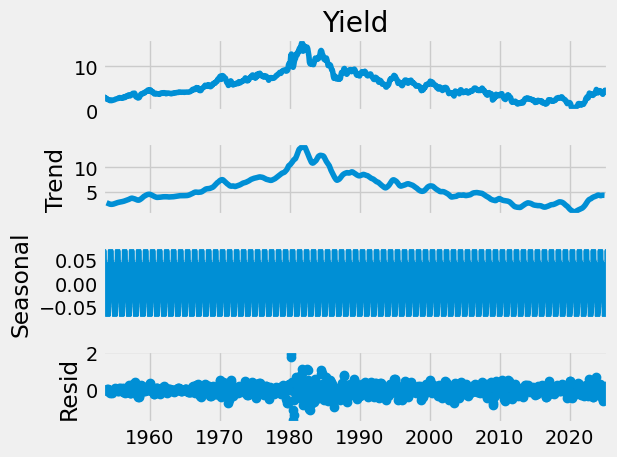

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_monthly["Yield"], model='additive')
result.plot()
plt.show()

### Time Series Decomposition Analysis of 10-Year U.S. Treasury Yields

The additive decomposition of the monthly U.S. 10-Year Treasury Yield reveals the following insights:

- **Trend Component**:  
  The trend line shows a clear rise from the 1960s through the early 1980s, peaking around 1981–1982 — a period historically known for high inflation and interest rates in the U.S. Following that, the yield declined steadily into the 2000s and remained relatively flat or slightly increasing post-2010.

- **Seasonal Component**:  
  The seasonal component appears minimal and tightly bounded around zero. This indicates that Treasury yields do not exhibit strong seasonality, which makes sense since bond yields are more influenced by macroeconomic policies and market conditions rather than seasonal cycles.

- **Residual Component**:  
  The residuals (random noise) fluctuate around zero without any strong patterns. There are a few spikes (e.g., early 1980s, 2008–2009 financial crisis), but overall, the residuals seem fairly white-noise-like, which suggests the model captured most of the signal in the trend.

#### Conclusion:
The decomposition confirms that the long-term trend dominates the behavior of the 10-Year Treasury Yield, with negligible seasonal influence.


## 6. Conduct a Dickey-Fuller test to check for stationarity (ADF Test)

In [35]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_monthly['Yield'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.426598
p-value                          0.569460
Number of Lags Used             21.000000
Number of Observations Used    845.000000
Critical Value (1%)             -3.438112
Critical Value (5%)             -2.864966
Critical Value (10%)            -2.568595
dtype: float64


### ADF Test Conclusion

The Augmented Dickey-Fuller (ADF) test results show that the **p-value is 0.596**, which is well above the standard 0.05 threshold. Additionally, the test statistic (-1.4266) is **greater than all the critical values** at the 1%, 5%, and 10% levels.

This means we **fail to reject the null hypothesis**, and therefore conclude that the series **is not stationary**.

We need to difference the data and re-run the ADF test on the transformed series to achieve stationarity.

## 7. If not stationary, conduct a round of differencing and repeat step 6

In [40]:
# Differencing
df_diff = df_monthly.diff().dropna()

In [42]:
# ADF test again
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(df_diff['Yield'])

Dickey-Fuller Stationarity test:
Test Statistic                -7.116684e+00
p-value                        3.814817e-10
Number of Lags Used            2.100000e+01
Number of Observations Used    8.440000e+02
Critical Value (1%)           -3.438122e+00
Critical Value (5%)           -2.864971e+00
Critical Value (10%)          -2.568597e+00
dtype: float64


### ADF Test After First Differencing

After differencing the time series once, the Augmented Dickey-Fuller (ADF) test result shows a **test statistic of -7.1167** and a **p-value of 8.31e-10**, which is far below the 0.05 threshold.

Since the test statistic is also **less than all critical values** at the 1%, 5%, and 10% levels, we can confidently **reject the null hypothesis**.

#### Conclusion:
The differenced U.S. Treasury Yield series is now **stationary**


## Step 8: Plotting data’s autocorrelations and Final Insights

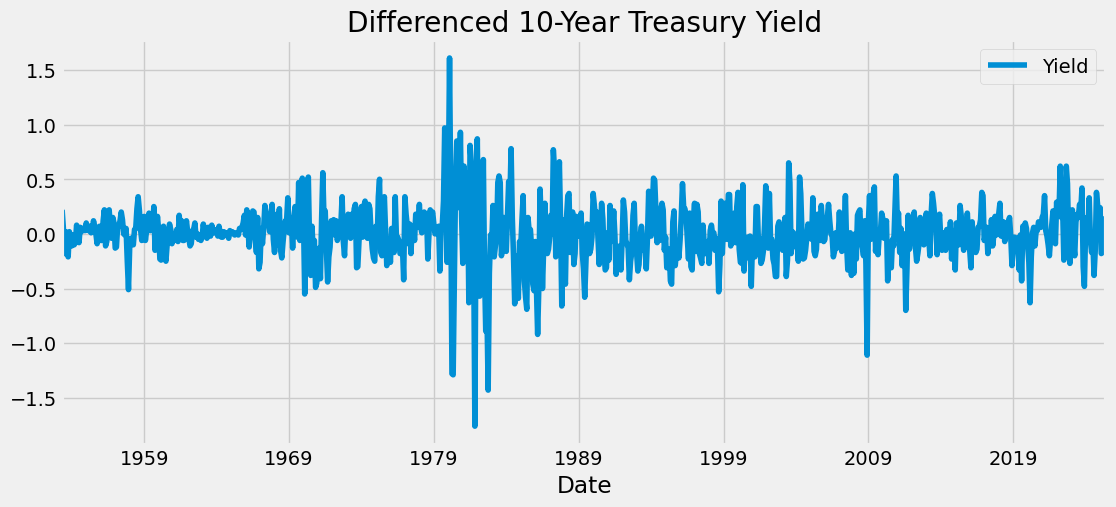

In [49]:
df_diff.plot(figsize=(12, 5), title="Differenced 10-Year Treasury Yield")
plt.grid(True)
plt.show()

In [51]:
dickey_fuller(df_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.116684e+00
p-value                        3.814817e-10
Number of Lags Used            2.100000e+01
Number of Observations Used    8.440000e+02
Critical Value (1%)           -3.438122e+00
Critical Value (5%)           -2.864971e+00
Critical Value (10%)          -2.568597e+00
dtype: float64


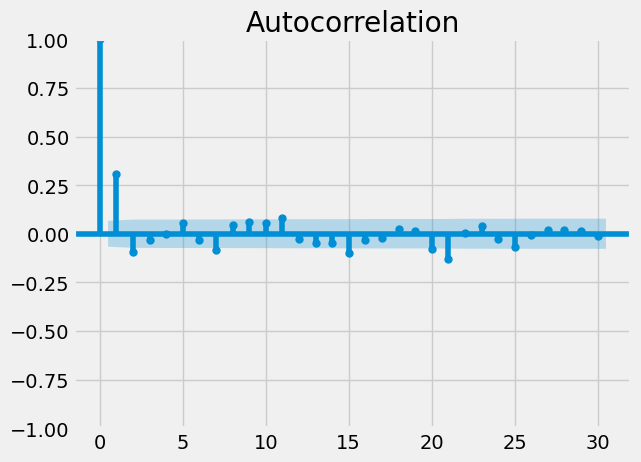

In [55]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots
plot_acf(df_diff)
plt.show()

### Autocorrelation (ACF) Analysis of Differenced U.S. Treasury Yield Series

The autocorrelation plot (ACF) of the first-differenced 10-Year Treasury Yield series provides insight into the remaining structure of the data after stationarization.

#### Key Observations:
- **Lag 1** shows a strong positive autocorrelation, which is expected in many financial and economic time series, even after differencing.
- **Subsequent lags** (Lag 2 onward) show rapidly declining autocorrelations, most of which fall within the 95% confidence interval bands (represented by the shaded blue area). This suggests that there is **minimal autocorrelation** remaining in the series.

#### Interpretation:
- The differencing has effectively removed most of the serial correlation from the original series, indicating the data is now **stationary and largely free of predictable patterns**.